#Exploring Patterns of Population Structure and Environmental Associations to Aridity Across the Range of Loblolly Pine

##Introduction

In this set of analyses, we will be making use of data from the Eckert et al. 2010 paper to explore patterns of phenotypic and environmental associations among populations of loblolly pine.


###Abstract

Natural populations of forest trees exhibit striking phenotypic adaptations to diverse environmental
gradients, thereby making them appealing subjects for the study of genes underlying ecologically relevant phenotypes. Here, we use a genome-wide data set of single nucleotide polymorphisms genotyped across 3059 functional genes to study patterns of population structure and identify loci associated with aridity across the natural range of loblolly pine (Pinus taeda L.). Overall patterns of population structure, as inferred using principal components and Bayesian cluster analyses, were consistent with three genetic clusters likely resulting from expansions out of Pleistocene refugia located in Mexico and Florida. A novel application of association analysis, which removes the confounding effects of shared ancestry on correlations between genetic and environmental variation, identified five loci correlated with aridity. These loci were primarily involved with abiotic stress response to temperature and drought. A unique set of 24 loci was identified as FST outliers on the basis of the genetic clusters identified previously and after accounting for expansions out of Pleistocene refugia. These loci were involved with a diversity of physiological processes. Identification of nonoverlapping sets of loci highlights the fundamental differences implicit in the use of either method and suggests a pluralistic, yet complementary, approach to the identification of genes underlying ecologically relevant phenotypes.


##Overview of tasks

In general, what you will be doing is working your way from loading and saving data related to this study, to corrections for population structure, to looking for associations between genotypes and phenotypes, genotypes and the environment (`Bayenv2`), and genotypes+phenotypes+environment (`SQUAT`)

## This notebook

This notebook gets you working with Bayenv2 data.  I've done a lot of the upfront work for you, so just worry about interpretation rather than running things.  Code to run is included, of course.

As with the previous notebook, execute the cell with the imports and continue

In [2]:
import os, sys
from IPython.display import Image
import pandas as pd
from __future__ import division
import numpy as np
import rpy2
from rpy2 import robjects as ro
import pandas.rpy.common as com
import matplotlib.pyplot as plt
import seaborn as sns
import operator
import scipy as sp
import traceback
from sklearn import preprocessing
from IPython.parallel import Client
from subprocess import Popen, PIPE
import shutil
from IPython.display import FileLink, FileLinks, Image
import psutil
import multiprocessing
from hdfstorehelper import HDFStoreHelper
import warnings
import pandas
import dill
import statsmodels as sm
import statsmodels.formula.api as smf
from scipy.stats.stats import pearsonr
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
warnings.simplefilter("ignore", pandas.io.pytables.PerformanceWarning)
%matplotlib inline

%load_ext rpy2.ipython
pd.set_option('display.width', 80)
pd.set_option('max.columns', 30)

%load_ext autoreload
%autoreload 2

sns.set_context("talk")

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
r = ro.r

In [4]:
hdf = HDFStoreHelper("data.hd5")

In [5]:
trait_name = str(dill.load(open("trait_name.dill")))

In [6]:
trait_name

'fructose'

####Let's load that Bayenv data from before

In [7]:
bayenv_df = hdf.get("bayenv_df")

In [8]:
bayenv_df.head()

,county,state,lat,long,county_state,countyid,0-10037-01-257,0-10040-02-394,0-10044-01-392,0-10048-01-60,0-10051-02-166,0-10054-01-402,0-10067-03-111,0-10079-02-168,0-10112-01-169,...,UMN-CL299Contig1-01-46,UMN-CL306Contig1-04-261,UMN-CL307Contig1-04-143,UMN-CL319Contig1-03-131,UMN-CL326Contig1-05-421,UMN-CL339Contig1-05-39,UMN-CL34Contig1-03-89,UMN-CL353Contig1-04-64,UMN-CL362Contig1-07-133,UMN-CL363Contig1-01-233,UMN-CL379Contig1-12-117,UMN-CL424Contig1-03-94,UMN-CL54Contig1-07-88,UMN-CL91Contig1-02-246,UMN-CL97Contig
0,CHEROKEE,GA,34.24000,-84.47000,CHEROKEE_GA,NaN,22,12,22,22,11,12,11,11,12,...,11,11,11,12,12,11,12,11,NA,11,11,11,11,11,12
1,BARTOW,GA,34.24000,-84.84000,BARTOW_GA,NaN,11,11,22,22,11,12,11,12,11,...,11,11,11,11,11,11,11,11,22,11,11,12,12,11,22
3,KING & QUEEN,VA,37.66986,-76.87746,KING & QUEEN_VA,NaN,11,22,11,11,12,11,11,11,11,...,11,11,11,11,11,11,12,11,NA,12,11,12,12,11,11
4,KING & QUEEN,VA,37.66986,-76.87746,KING & QUEEN_VA,NaN,11,12,11,NA,11,12,11,11,11,...,11,11,12,11,11,11,12,11,11,12,11,12,11,12,11
5,NEW KENT,VA,37.51160,-76.97319,NEW KENT_VA,NaN,12,11,12,22,11,12,11,11,11,...,11,11,12,11,12,11,12,11,NA,12,11,12,11,12,12


####We need to add county and stuff back in, as well.

In [9]:
county_id = dill.load(open("county_id.dill"))

In [10]:
def add_county_id(row):
    key = "%s_%s" % (row.county,row.state)
    if key in county_id:
        return county_id[key]
    return np.nan
bayenv_df['countyid'] = bayenv_df.apply(add_county_id, axis=1)

In [11]:
bayenv_df.head(10)

,county,state,lat,long,county_state,countyid,0-10037-01-257,0-10040-02-394,0-10044-01-392,0-10048-01-60,0-10051-02-166,0-10054-01-402,0-10067-03-111,0-10079-02-168,0-10112-01-169,...,UMN-CL299Contig1-01-46,UMN-CL306Contig1-04-261,UMN-CL307Contig1-04-143,UMN-CL319Contig1-03-131,UMN-CL326Contig1-05-421,UMN-CL339Contig1-05-39,UMN-CL34Contig1-03-89,UMN-CL353Contig1-04-64,UMN-CL362Contig1-07-133,UMN-CL363Contig1-01-233,UMN-CL379Contig1-12-117,UMN-CL424Contig1-03-94,UMN-CL54Contig1-07-88,UMN-CL91Contig1-02-246,UMN-CL97Contig
0,CHEROKEE,GA,34.24000,-84.47000,CHEROKEE_GA,NaN,22,12,22,22,11,12,11,11,12,...,11,11,11,12,12,11,12,11,NA,11,11,11,11,11,12
1,BARTOW,GA,34.24000,-84.84000,BARTOW_GA,NaN,11,11,22,22,11,12,11,12,11,...,11,11,11,11,11,11,11,11,22,11,11,12,12,11,22
3,KING & QUEEN,VA,37.66986,-76.87746,KING & QUEEN_VA,NaN,11,22,11,11,12,11,11,11,11,...,11,11,11,11,11,11,12,11,NA,12,11,12,12,11,11
4,KING & QUEEN,VA,37.66986,-76.87746,KING & QUEEN_VA,NaN,11,12,11,NA,11,12,11,11,11,...,11,11,12,11,11,11,12,11,11,12,11,12,11,12,11
5,NEW KENT,VA,37.51160,-76.97319,NEW KENT_VA,NaN,12,11,12,22,11,12,11,11,11,...,11,11,12,11,12,11,12,11,NA,12,11,12,11,12,12
6,WARREN,NC,34.80551,-76.80890,WARREN_NC,NaN,11,22,22,12,11,12,11,11,11,...,12,11,12,12,11,11,11,11,11,11,11,12,22,11,12
7,NORTHAMPTON,NC,36.39032,-77.42219,NORTHAMPTON_NC,NaN,12,12,12,11,12,12,11,11,11,...,11,11,11,12,12,11,12,11,12,12,11,11,12,11,22
8,COLUMBUS,NC,34.33010,-78.70453,COLUMBUS_NC,11,NA,22,11,11,11,11,11,11,11,...,11,NA,12,11,11,11,11,11,NA,11,11,12,11,12,22
10,ONSLOW,NC,34.75963,-77.40977,ONSLOW_NC,26,11,22,12,11,11,12,11,11,11,...,11,11,11,11,12,11,12,11,12,11,11,11,12,11,11
11,ONSLOW,NC,34.75963,-77.40977,ONSLOW_NC,26,11,12,NA,12,11,12,11,11,11,...,11,11,11,12,NA,11,11,11,11,11,11,11,12,11,12


In [12]:
bayenv_df = bayenv_df[bayenv_df.countyid > 0]

In [13]:
bayenv_df.head()

,county,state,lat,long,county_state,countyid,0-10037-01-257,0-10040-02-394,0-10044-01-392,0-10048-01-60,0-10051-02-166,0-10054-01-402,0-10067-03-111,0-10079-02-168,0-10112-01-169,...,UMN-CL299Contig1-01-46,UMN-CL306Contig1-04-261,UMN-CL307Contig1-04-143,UMN-CL319Contig1-03-131,UMN-CL326Contig1-05-421,UMN-CL339Contig1-05-39,UMN-CL34Contig1-03-89,UMN-CL353Contig1-04-64,UMN-CL362Contig1-07-133,UMN-CL363Contig1-01-233,UMN-CL379Contig1-12-117,UMN-CL424Contig1-03-94,UMN-CL54Contig1-07-88,UMN-CL91Contig1-02-246,UMN-CL97Contig
8,COLUMBUS,NC,34.33010,-78.70453,COLUMBUS_NC,11,NA,22,11,11,11,11,11,11,11,...,11,NA,12,11,11,11,11,11,NA,11,11,12,11,12,22
10,ONSLOW,NC,34.75963,-77.40977,ONSLOW_NC,26,11,22,12,11,11,12,11,11,11,...,11,11,11,11,12,11,12,11,12,11,11,11,12,11,11
11,ONSLOW,NC,34.75963,-77.40977,ONSLOW_NC,26,11,12,NA,12,11,12,11,11,11,...,11,11,11,12,NA,11,11,11,11,11,11,11,12,11,12
12,GEORGETOWN,SC,33.36318,-79.30539,GEORGETOWN_SC,14,NA,12,NA,NA,11,12,11,11,12,...,11,11,12,NA,12,11,NA,11,12,11,11,11,NA,11,NA
13,BEAUFORT,NC,35.55349,-77.05205,BEAUFORT_NC,2,11,NA,12,12,11,22,11,11,11,...,11,12,11,11,11,11,11,11,12,11,11,22,11,12,11


In [14]:
def convert_to_snpassoc(col):
    if "-" in col.name:
        freqs = af[col.name]
        trans = {11: "%s/%s" % (freqs["A"], freqs["A"]),
                12: "%s/%s" % (freqs["A"], freqs["a"]),
                22: "%s/%s" % (freqs["a"], freqs["a"]),
                "NA":"NA"}
        return col.apply(lambda x: trans[x])
    return col

def is_homozygous(gt):
    if len(set([x.strip() for x in gt.split("/")])) == 1:
        return True
    return False

def get_allele_counts(counts):
    a = {}
    het = 0
    for gt in counts.index:
        alleles = None
        if "/" in gt:
            alleles = [x.strip() for x in gt.split("/")]
        else:
            alleles = gt
        for allele in alleles:
            if not allele in a:
                a[allele] = 0
            a[allele] += counts[gt]
        if not is_homozygous(gt):
            het += counts[gt]
    return sorted(a.items(), key=lambda x: x[1], reverse=True), het


def get_correction(n):
    #for finite sample size
    return (2*n)/(2*n-1)

def get_allele_freqs(locus):
    locus = locus[locus != '?/?']
    locus = locus[locus != 'NA']
    c = locus.value_counts()
    c = c.sort(inplace=False, ascending=False)
    allele_counts = get_allele_counts(c)
    total_alleles = 2.0*sum(c)
    num_individuals = sum(c)
    A = ""
    a = ""
    P = 0
    Q = 0
    if len(allele_counts[0]) == 2:
        A = allele_counts[0][0][0]
        a = allele_counts[0][1][0]
        P = allele_counts[0][0][1]
        Q = allele_counts[0][1][1]
    else:
        A = allele_counts[0][0][0]
        P = P = allele_counts[0][0][1]
    PQ = allele_counts[-1]
    p = P/total_alleles
    q = Q/total_alleles
    assert p + q == 1.0
    He = 2 * p * q * get_correction(num_individuals)
    Ho = PQ*1.0/num_individuals
    Fis = 1 - (Ho/He)
    #print p, q, He, Ho, Fis
    ret = pd.Series({"p":p, 
                      "q":q,
                      "P":P,
                      "Q":Q,
                      "He":He,
                      "Ho":Ho, 
                      "Fis":Fis,
                    "PQ": PQ,
                    "total_alleles":total_alleles,
                    "num_indiv":num_individuals,
                    "A":A,
                    "a":a})
    return ret

In [15]:
af = hdf.get("af")
bayenv_df = bayenv_df.apply(convert_to_snpassoc)

####We need to get allele frequencies by population

This also takes a few minutes.

In [17]:
pop_allele_freqs = {}
for pop,data in bayenv_df.groupby("countyid"):
    print "getting allele freqs for pop % d" % pop
    pop_allele_freqs[pop] = data.ix[:,6:].apply(get_allele_freqs)

getting allele freqs for pop  1
getting allele freqs for pop  2
getting allele freqs for pop  3
getting allele freqs for pop  4
getting allele freqs for pop  5
getting allele freqs for pop  6
getting allele freqs for pop  7
getting allele freqs for pop  8
getting allele freqs for pop  9
getting allele freqs for pop  10
getting allele freqs for pop  11
getting allele freqs for pop  12
getting allele freqs for pop  13
getting allele freqs for pop  14
getting allele freqs for pop  15
getting allele freqs for pop  16
getting allele freqs for pop  17
getting allele freqs for pop  18
getting allele freqs for pop  19
getting allele freqs for pop  20
getting allele freqs for pop  21
getting allele freqs for pop  22
getting allele freqs for pop  23
getting allele freqs for pop  24
getting allele freqs for pop  25
getting allele freqs for pop  26
getting allele freqs for pop  27
getting allele freqs for pop  28
getting allele freqs for pop  29
getting allele freqs for pop  30
getting allele freq

####The allele freqs data from above also returns counts of each allele, which is really what we need for Bayenv.  

Remember that data we called, `af` before?  This is the same, but for each population.  I call the counts of major and minor allele, P and Q, and their frequencies p and q, respectively.  Probably a bad habit, I admit.

Let's get those counts for the SNPs and put it into a file that Bayenv can understand.  The Bayenv file format also sucks, and it's worth saying it to all of your friends.  Who ends lines with a tab?

In [18]:
def get_bayenv_snp(snp_name, popids):
    P = []
    Q = []
    for popid in popids:
        P.append(pop_allele_freqs[popid].ix["P",name])
        Q.append(pop_allele_freqs[popid].ix["Q",name])
    return P, Q

def write_bayenv_snp(fh_snp, fh_names, name, P, Q):
    if sum(Q) > 0: #exclude monomorphic loci
        if fh_names:
            fh_names.write("%s\n" % name)
        P = [str(x) for x in P]
        Q = [str(x) for x in Q]
        fh_snp.write("%s\t\n" % "\t".join(Q))
        fh_snp.write("%s\t\n" % "\t".join(P))

In [19]:
bayenv_dir = "bayenv"
snp_names = [x for x in bayenv_df.columns if "-" in x]
popids = sorted(bayenv_df.countyid.unique())

if not os.path.exists(bayenv_dir):
    os.mkdir(bayenv_dir)

with open("bayenv.txt", "w") as o:
    with open("bayenv_names.txt", "w") as n:
        for name in snp_names:
            P,Q = get_bayenv_snp(name, popids)
            write_bayenv_snp(o, n, name, P, Q)

####Let's look at the first two (wrapped) lines of the file.  

Look familiar?

In [20]:
!head -n2 bayenv.txt

4	23	3	4	5	5	4	6	3	5	3	14	4	4	8	4	5	2	5	3	7	3	7	7	7	5	12	4	3	1	3	37	3	5	
14	45	11	8	17	11	6	20	9	5	7	28	12	14	26	8	15	10	17	9	19	9	9	7	15	19	20	14	7	13	7	89	11	9	


####Copy that file into your bayenv directory for use later, as below.  

Have you noticed that IPython can also call shell commands on the server?

In [ ]:
!cp bayenv.txt bayenv/

##Run Bayenv to create variance-covariance matrix

```bash
    cd bayenv && /gdc_home4/cfried/src/bayenv2/bayenv2 -i bayenv.txt -p 30 -k 100000 -r 63479 > matrix.out
```

* -p number of populations (`len(popids)`)
* -k mcmc generations
* -r random seed

This has already been done for you since it takes several hours for 100,000 generations.  This same data takes about 15 hours for 1,000,000 generations.

####As with all things Bayesian, it's good to look at the data to make sure that the MCMC chain is mixing properly.

This is just one way, using pearson correlation, and checking out the correlation between the last matrix and all previous ones.  You can imagine any number of scenarios, I'm sure, but it seems to overall converge very quickly.

In [21]:
vcovs = []
current = None
for line in open("bayenv/matrix.out"):
    if "VAR-COVAR" in line:
        current = []
        vcovs.append(current)
    if isinstance(current, list):
        current.append(line.strip().split("\t"))
    

In [22]:
vcov_dfs = []
for i, elem in enumerate(vcovs):
    vcov_dfs.append(pd.DataFrame(vcovs[i][1:]).T)

In [23]:
matrix_correlation = np.zeros((len(vcovs), len(vcovs)))
for i in xrange(len(vcovs)):
    if i == len(vcovs)-1:
        for j in xrange(i+1):
            idf = vcov_dfs[i]
            jdf = vcov_dfs[j]
            idf = idf.ix[:,:len(idf)-1]
            jdf = jdf.ix[:,:len(jdf)-1]
            idf = [float(x) for x in idf.values.flatten()]
            jdf = [float(x) for x in jdf.values.flatten()]
            assert len(idf) == len(jdf)
            matrix_correlation[i, j] = sp.stats.pearsonr(idf, jdf)[0]
            matrix_correlation[j, i] = matrix_correlation[i, j]

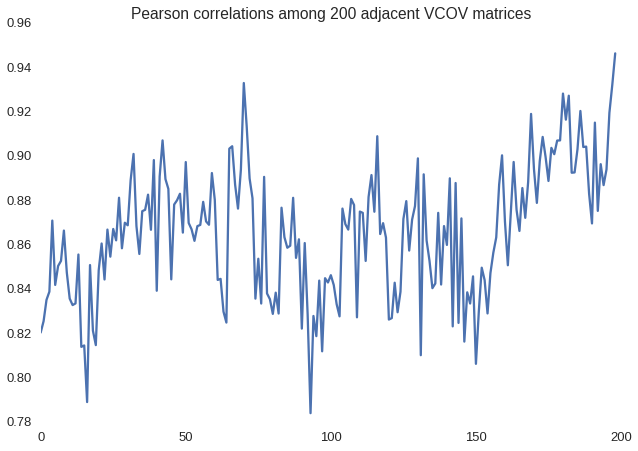

In [24]:
ys = []
for i in xrange(len(matrix_correlation)):
    for j in xrange(i):
        if i == len(vcovs)-1:
            ys.append(matrix_correlation[i,j])
plt.plot(range(len(ys)),ys)
plt.title("Pearson correlations among %d adjacent VCOV matrices" % len(matrix_correlation))
plt.show()

####Does this tell you anything about the process?  Are you comfortable choosing the last matrix?

####One way to view the covariance structure of a matrix (a moderately sized one) is a heatmap. 

In Python, here's one way.

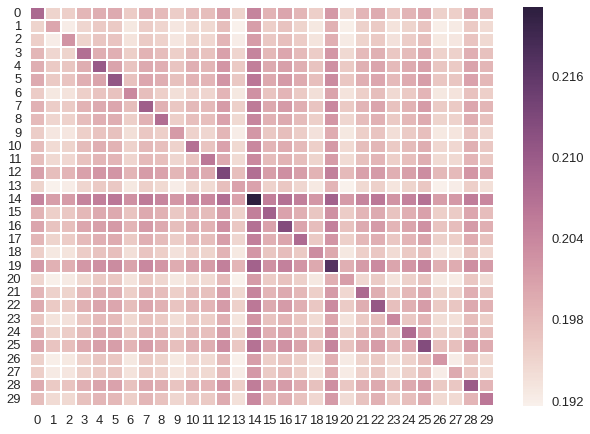

In [25]:
vcov = pd.read_csv("bayenv/matrix_last.out", sep="\t", header=None)
vcov = vcov.ix[:,:len(vcov.columns)-2]
sns.heatmap(vcov)
plt.show()

## Run Bayenv mcmc

The code below will walk you through getting this all set up, but it will not run it. Bayenv is best run with GNU `parallel` I've found, and also pinning to single CPUs because of how their software is programmed.  

In [26]:
data_ai = hdf.get("data_ai")
data_ai['county_state'] = data_ai.apply(lambda row: "%s_%s" % (row.County, row.State), axis=1)
bayenv_df_ai = bayenv_df.merge(data_ai, on='county_state')
bayenv_df_ai.head()

,county,state,lat,long,county_state,countyid,0-10037-01-257,0-10040-02-394,0-10044-01-392,0-10048-01-60,0-10051-02-166,0-10054-01-402,0-10067-03-111,0-10079-02-168,0-10112-01-169,...,UMN-CL34Contig1-03-89,UMN-CL353Contig1-04-64,UMN-CL362Contig1-07-133,UMN-CL363Contig1-01-233,UMN-CL379Contig1-12-117,UMN-CL424Contig1-03-94,UMN-CL54Contig1-07-88,UMN-CL91Contig1-02-246,UMN-CL97Contig,County,State,AI_Q1,AI_Q2,AI_Q3,AI_Q4
0,COLUMBUS,NC,34.3301,-78.70453,COLUMBUS_NC,11,NA,A/A,C/C,G/G,G/G,G/G,A/A,G/G,A/A,...,G/G,A/A,NA,G/G,A/A,C/A,G/G,C/A,A/A,COLUMBUS,NC,6.737349,1.031164,1.017138,2.443279
1,COLUMBUS,NC,34.3301,-78.70453,COLUMBUS_NC,11,A/G,C/C,C/C,G/A,G/G,G/A,A/A,G/G,A/A,...,G/G,A/A,C/A,G/G,A/A,C/A,G/A,C/C,G/A,COLUMBUS,NC,6.737349,1.031164,1.017138,2.443279
2,COLUMBUS,NC,34.3301,-78.70453,COLUMBUS_NC,11,A/G,C/C,G/G,G/G,G/A,G/A,A/A,G/G,A/A,...,G/G,A/A,C/C,G/A,A/A,C/C,G/G,C/C,G/G,COLUMBUS,NC,6.737349,1.031164,1.017138,2.443279
3,COLUMBUS,NC,34.3301,-78.70453,COLUMBUS_NC,11,A/A,C/A,C/G,G/G,G/A,G/G,A/A,G/A,A/A,...,G/C,A/A,C/C,G/G,A/A,C/C,G/G,C/C,G/A,COLUMBUS,NC,6.737349,1.031164,1.017138,2.443279
4,COLUMBUS,NC,34.3301,-78.70453,COLUMBUS_NC,11,A/G,C/A,C/G,G/G,G/G,G/G,A/A,G/G,A/A,...,G/G,A/A,C/C,G/G,A/A,C/A,A/A,C/C,G/A,COLUMBUS,NC,6.737349,1.031164,1.017138,2.443279


In [27]:
bayenv_df_ai.shape

(388, 3094)

In [28]:
def get_bayenv_env(data):
    E = pd.Series()
    for col in data.columns[:-1]:
        E[col] = data[col].values[0]
    return E

ai_cols = [x for x in bayenv_df_ai if 'AI_' in x]
ai_cols.append('countyid')
bayenv_df_ai_groups = bayenv_df_ai.ix[:,ai_cols].groupby("countyid")
env_ai = []
for popid in popids:
    env_ai.append(get_bayenv_env(bayenv_df_ai_groups.get_group(popid))) 
env_ai_df = pd.DataFrame(env_ai).T
env_ai_df = env_ai_df.apply(preprocessing.scale, axis=1)
env_ai_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,...,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33
AI_Q1,-0.543192,-0.224174,-0.264691,-0.466561,-0.445484,-0.292720,-0.580444,1.947866,0.955898,-0.468096,0.106716,-0.401456,-1.109503,-0.351097,1.784894,...,0.739313,-0.849102,-0.143519,-0.492753,-1.346197,-0.154306,-0.322422,1.518583,-0.748163,-0.723340,1.638606,-0.870276,1.948834,-1.172916,2.073411
AI_Q2,-1.249341,0.202634,0.209415,-0.233210,-0.239005,-1.064694,-1.493350,1.365373,1.336554,0.379529,0.047695,0.239023,-1.465602,-0.013303,1.093395,...,0.216930,1.362245,0.634253,-1.151339,1.175674,-0.971686,0.309209,1.112855,-1.439820,-1.253046,0.926881,-1.240997,1.468511,-1.366513,1.042215
AI_Q3,-0.309792,0.633278,0.889383,0.219365,1.658925,-0.657004,-0.680271,-0.421831,-0.250408,-1.155304,0.751771,1.164951,-0.654465,1.352265,-0.745726,...,-0.838245,2.218533,1.473085,-0.877542,-1.363928,-0.526432,1.477762,-0.579602,-0.503145,-0.890514,-0.633030,-0.525839,-0.622012,-0.733373,-0.372875
AI_Q4,-0.557166,-0.684624,-0.865643,-0.674399,-0.498381,-0.182639,-0.290664,1.703533,0.983468,1.225337,-0.661674,-0.546989,-0.544675,-0.226710,1.328161,...,0.802163,-1.620242,-0.273565,-0.068398,0.617248,-0.542738,-0.494581,1.581698,-0.338859,0.250164,1.503820,-0.761220,1.537409,-1.111650,1.236709


In [29]:
def add_last_column(row):
    row[len(row)] = ""
    return row 

env_ai_df.apply(add_last_column, axis=1).to_csv("envmatrix.txt", 
                                               header=None,
                                                index=True,
                                               sep="\t")

In [30]:
!cp bayenv/matrix_last.out .

In [33]:
def setup_bayenv_cmd(snpfile, name):
    work_dir = os.path.join(os.path.abspath("."), "bayenv")
    bayenv = "/gdc_home4/cfried/src/bayenv2/bayenv2"
    bayenv_matrix = "matrix_last.out"
    bayenv_seed = -47372
    bayenv_pops = 12
    bayenv_runs = 100000
    bayenv_environs = 4
    bayenv_envmatrix = "envmatrix.txt"
    bayenv_cmd = "cd %s/%s && %s -i %s -m %s -e %s -p %d -k %d -n %d -t -c -f -X -o %s" % (work_dir, 
                                                                                        name,
                                                                                        bayenv,
                                                                         snpfile,
                                                                         bayenv_matrix,
                                                                         bayenv_envmatrix,
                                                                         bayenv_pops,
                                                                     bayenv_runs,
                                                                     bayenv_environs,
                                                                             snpfile)
    shutil.copy(bayenv_matrix, os.path.join(work_dir, name))
    shutil.copy(bayenv_envmatrix, os.path.join(work_dir, name))
    return bayenv_cmd


In [34]:
cmds = []
if not os.path.exists(bayenv_dir):
    os.mkdir(bayenv_dir)

for name in snp_names:
    P,Q = get_bayenv_snp(name,popids)
    if sum(Q) > 0:
        file_dir = os.path.join(bayenv_dir, name)        
        if not os.path.exists(file_dir):
            os.mkdir(file_dir)
        o = open(os.path.join(file_dir, "%s.txt" % name), "w")
        write_bayenv_snp(o, None, name, P, Q)
        o.close()
        cmd = setup_bayenv_cmd(os.path.basename(o.name), name)
        cmds.append(cmd)

In [ ]:
with open("bayenv_jobs.txt", "w") as o:
    cpu = 0
    max_cpus = 20
    for cmd in cmds:
        c = cmd.split()
        c[2] = "&& taskset -c %d" % cpu
        o.write("%s\n" % " ".join(c))
        cpu += 1
        if cpu == max_cpus:
            cpu = 0
        

## Run all the commands

But don't, I already did it for you.

```bash
cat bayenv_jobs.txt | parallel -j 20 --eta --
```

####One of the commands looks like this, if you're curious

In [35]:
cmds[0]

u'cd /gdc_home5/groups/congenomics/day5/cfried/bayenv/0-10037-01-257 && /gdc_home4/cfried/src/bayenv2/bayenv2 -i 0-10037-01-257.txt -m matrix_last.out -e envmatrix.txt -p 12 -k 100000 -n 4 -t -c -f -X -o 0-10037-01-257.txt'

####We can iterate the bayenv directory and find all of the files that contain bf.  

Luckily none of my files have bf in the name other than the file extension. Be careful with regexes.

In [36]:
bf_files = !find {bayenv_dir} | grep bf
len(bf_files)

3071

In [37]:
bf_files[0:10]

['bayenv/0-10037-01-257/0-10037-01-257.txt.bf',
 'bayenv/0-10040-02-394/0-10040-02-394.txt.bf',
 'bayenv/0-10044-01-392/0-10044-01-392.txt.bf',
 'bayenv/0-10048-01-60/0-10048-01-60.txt.bf',
 'bayenv/0-10051-02-166/0-10051-02-166.txt.bf',
 'bayenv/0-10054-01-402/0-10054-01-402.txt.bf',
 'bayenv/0-10067-03-111/0-10067-03-111.txt.bf',
 'bayenv/0-10079-02-168/0-10079-02-168.txt.bf',
 'bayenv/0-10112-01-169/0-10112-01-169.txt.bf',
 'bayenv/0-10113-01-119/0-10113-01-119.txt.bf']

In [38]:
bf_data = {}
for b in bf_files:
    d = open(b).readlines()
    d = d[-1].strip().split("\t")[1:]
    if len(d) == 12:
        bf_data[os.path.basename(b).replace(".txt.bf","")] = d

In [39]:
bf = pd.DataFrame(bf_data).T.astype(float)
bf.shape

(3071, 12)

In [40]:
bf.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0-10037-01-257,0.48077,0.110340,0.083676,0.39448,0.080530,0.090586,0.37736,-0.000478,0.030644,0.39041,-0.004527,0.045087
0-10040-02-394,0.52960,0.026684,0.064060,0.33280,-0.047368,-0.031314,0.34282,-0.026610,-0.023414,0.33935,-0.012808,0.002103
0-10044-01-392,0.51486,-0.021421,-0.028081,0.43142,-0.000368,-0.016969,0.59593,0.021347,0.019529,0.57894,-0.073574,-0.045692
0-10048-01-60,0.43592,0.163270,0.060029,0.33337,0.027935,0.037953,0.63129,0.169120,0.185860,0.44389,-0.140190,-0.119620
0-10051-02-166,1.57010,-0.199040,-0.227580,0.43961,-0.028303,-0.096318,0.30620,0.001288,0.036288,0.41451,-0.031837,-0.079015


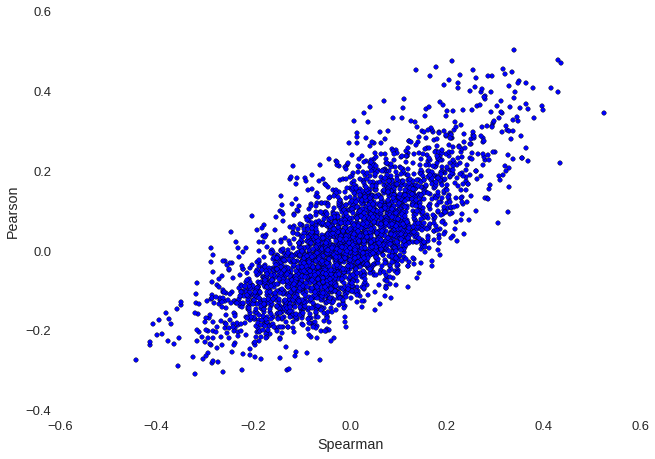

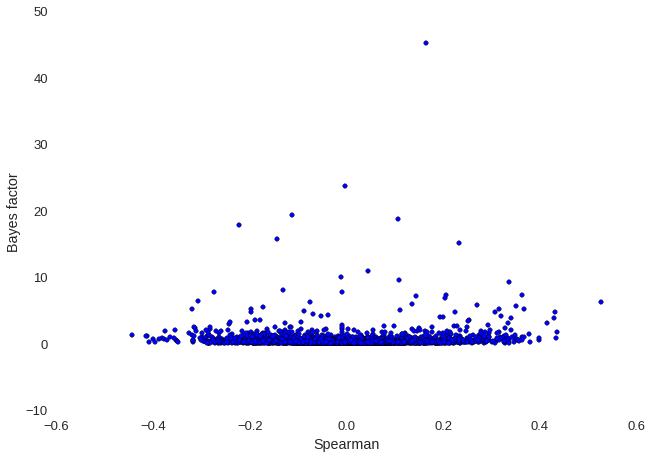

In [41]:
plt.scatter(bf.ix[:,1], bf.ix[:,2])
plt.xlabel("Spearman")
plt.ylabel("Pearson")
plt.show()

plt.scatter(bf.ix[:,1], bf.ix[:,0])
plt.xlabel("Spearman")
plt.ylabel("Bayes factor")
plt.show()

##Outlier analysis

In [42]:
def get_outliers(df, key, num_std):
    if key == "bf":
        key = 0
    elif key == "rho":
        key = 1  
    outliers = {}   
    ai = 0
    for i in xrange(key, len(df.columns), 3):
        d = df.ix[:,i]
        d_std = np.std(d)
        d_mean = np.mean(d)
        cutoffs = [d_mean + (num_std*d_std), d_mean - (num_std*d_std)]
        env = ai_cols[ai]
        outliers[env] = d[(d >= cutoffs[0]) | (d <= cutoffs[1])]
        ai += 1
    return outliers

In [43]:
def plot_outliers(df, key, num_std):
    if key == "bf":
        key = 0
    elif key == "rho":
        key = 1   
    ai = 0
    for i in xrange(key, len(df.columns), 3):
        d = df.ix[:,i]
        d_std = np.std(d)
        d_mean = np.mean(d)
        env = ai_cols[ai]
        ax = plt.gca()
        if key == 0:
            ax.set_yscale('log')
        plt.hist(d, bins=100)
        plt.xlim(np.min(d), d_mean+(num_std*d_std))
        plt.title("%s $\mu = %.4f \pm %.4f [%.4f, %.4f])$" % (env,
                                                            d_mean,
                                                            d_std,
                                                            np.min(d),
                                                            np.max(d)))
        plt.show()
        ai += 1

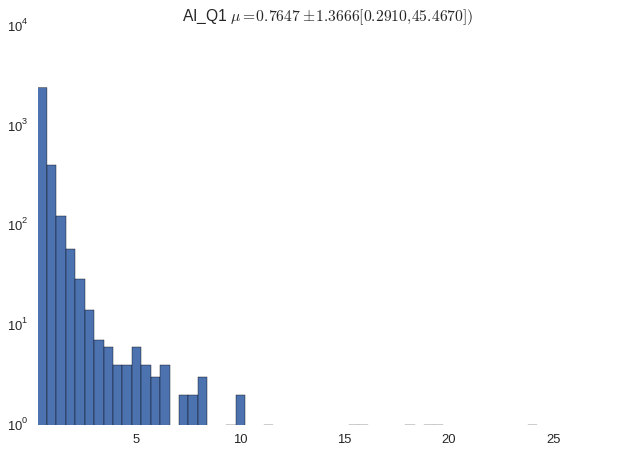

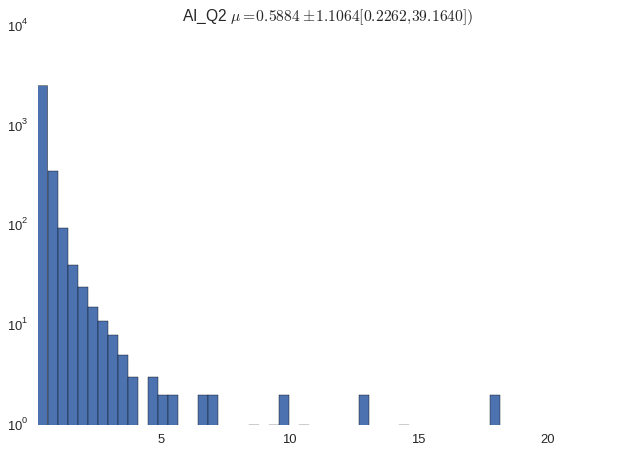

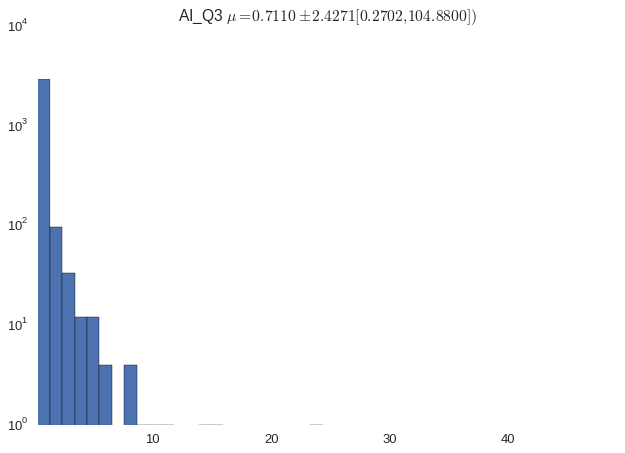

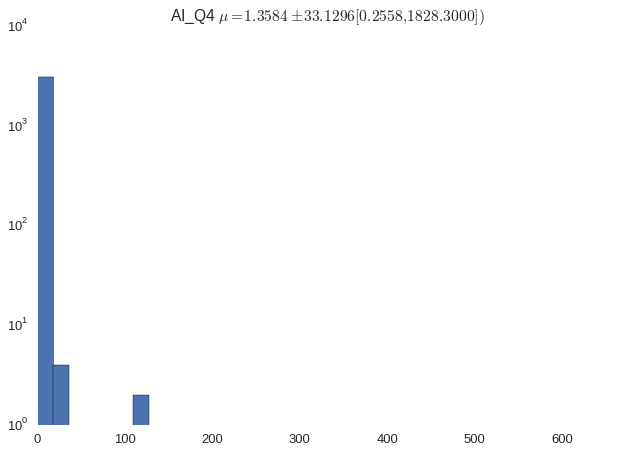

In [44]:
plot_outliers(bf, "bf", 20)

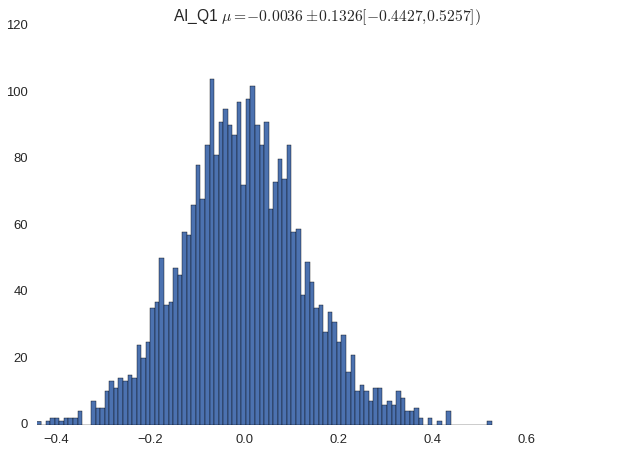

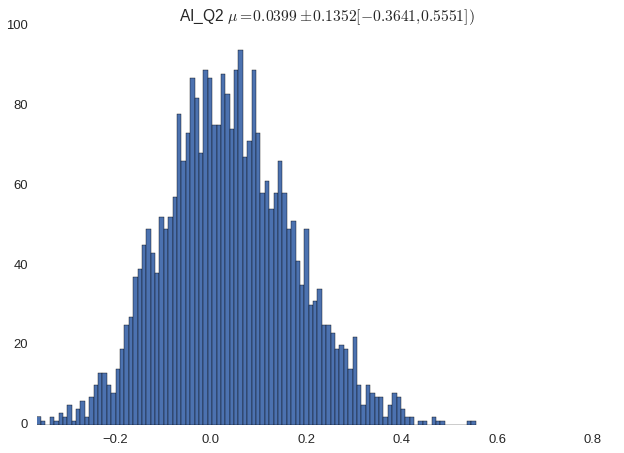

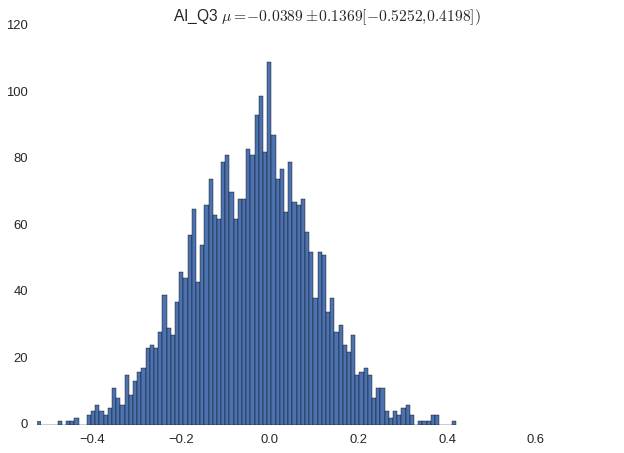

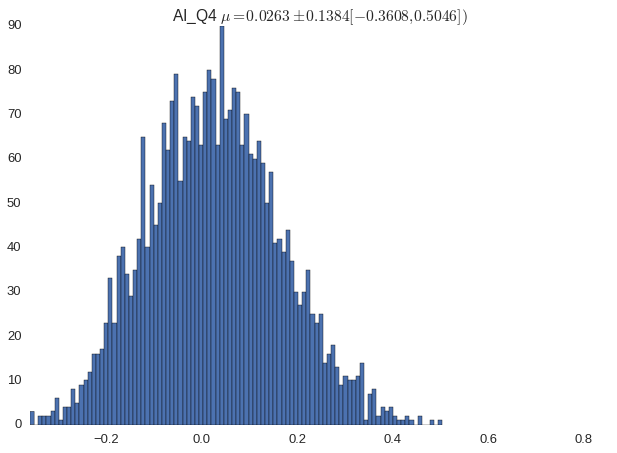

In [45]:
plot_outliers(bf, "rho", 6)

In [46]:
bf_outliers = get_outliers(bf, "bf", 6)    
rho_outliers = get_outliers(bf, "rho", 3)

In [47]:
%%R
library(VennDiagram)

Loading required package: grid


In [48]:
def draw_venn(outliers, title):
    keys = sorted(list(outliers.keys()))
    a1 = set(outliers[keys[0]].index)
    a2 = set(outliers[keys[1]].index)
    a3 = set(outliers[keys[2]].index)
    a4 = set(outliers[keys[3]].index)
    area1 = len(a1)
    area2 = len(a2)
    area3 = len(a3) 
    area4 = len(a4)
    n12 = len(a1.intersection(a2))
    n13 = len(a1.intersection(a3))
    n14 = len(a1.intersection(a4))
    n23 = len(a2.intersection(a3))
    n24 = len(a2.intersection(a4))
    n34 = len(a3.intersection(a4))
    n123 = len(set.intersection(a1, a2, a3))
    n124 = len(set.intersection(a1, a2, a4))
    n134 = len(set.intersection(a1, a3, a4))
    n234 = len(set.intersection(a2, a3, a4))
    n1234 = len(set.intersection(a1, a2, a3, a4))
    venn = "venn_%s.png" % title.replace(" ", "_")
    r("library(VennDiagram)")
    r("png('%s')" % venn)
    r('draw.quad.venn')(area1, 
                  area2,
                  area3,
                  area4,
                  n12,
                  n13,
                  n14,
                  n23,
                  n24,
                  n34,
                  n123,
                  n124,
                  n134,
                  n234,
                  n1234,
                       category=keys)
    r('dev.off()')
    return venn

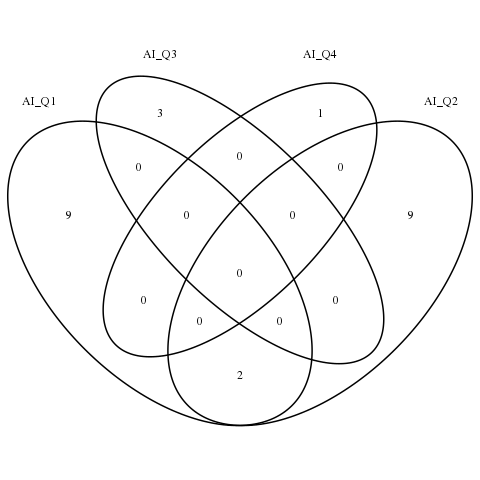

In [49]:
Image(draw_venn(bf_outliers, "Bayes factor outliers"))

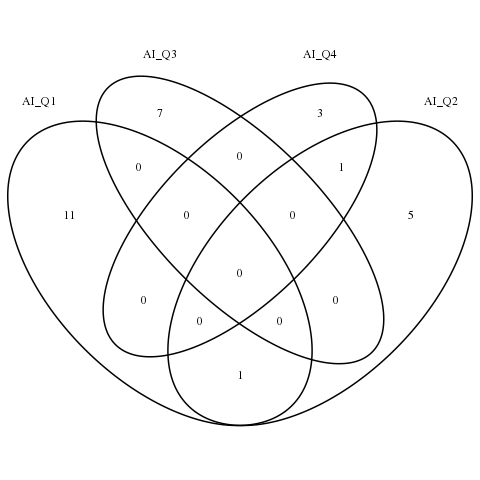

In [50]:
Image(draw_venn(rho_outliers, "Rho outliers"))

In [51]:
combined_outliers = {}
for key in bf_outliers:
    a = bf_outliers[key].index
    b = rho_outliers[key].index
    combined_outliers[key] = pd.Series(index=a.intersection(b))

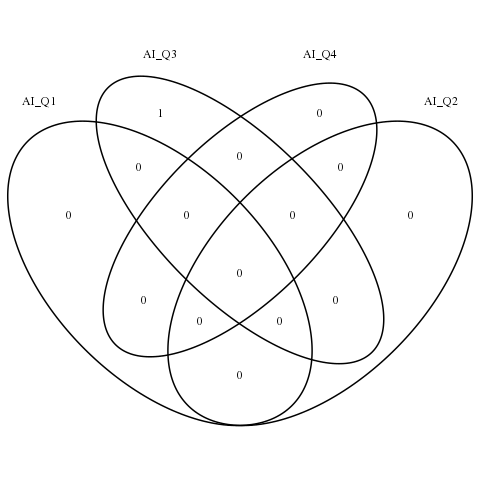

In [52]:
Image(draw_venn(combined_outliers, "combined"))

In [53]:
boxplot_data = {}
for key, val in bf_outliers.items():
    val = val.sort(inplace=False, ascending=False)
    boxplot_data[key] = {val.index[0]: val[0]}

In [54]:
boxplot_data

{u'AI_Q1': {'0-16142-02-130': 45.466999999999999},
 u'AI_Q2': {'2-5962-01-400': 39.164000000000001},
 u'AI_Q3': {'0-6552-02-139': 104.88},
 u'AI_Q4': {'0-4255-01-290': 1828.3}}

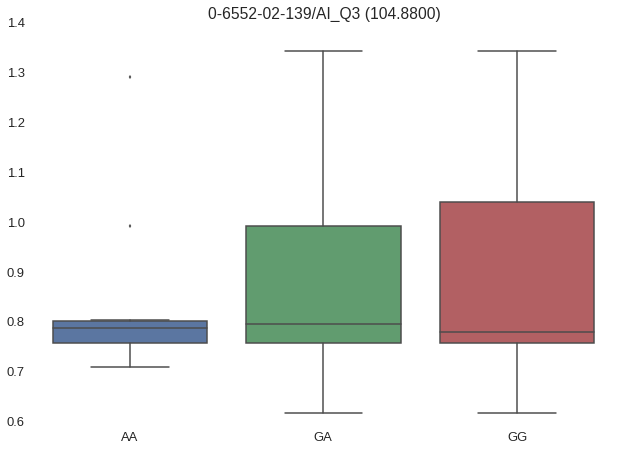

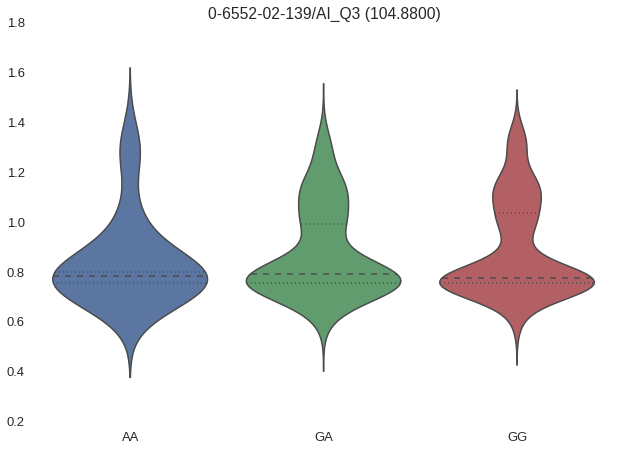

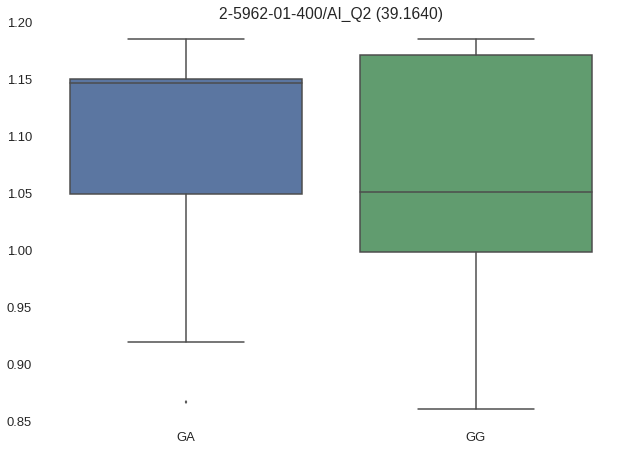

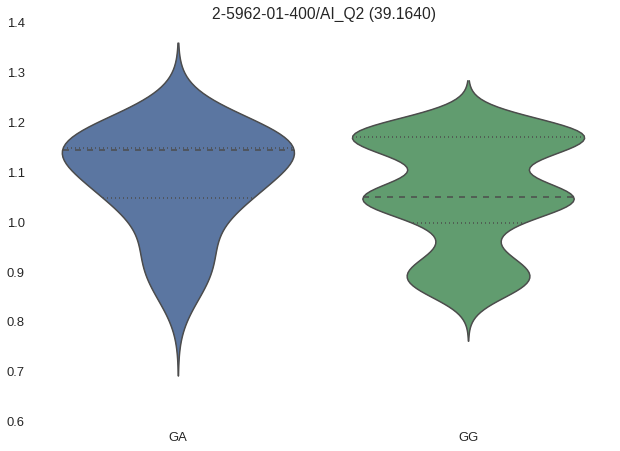

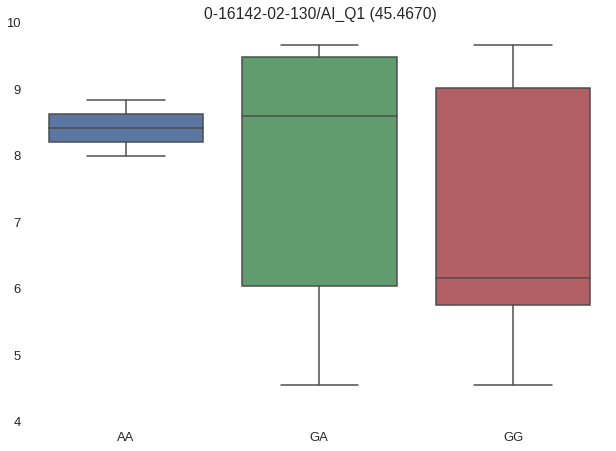

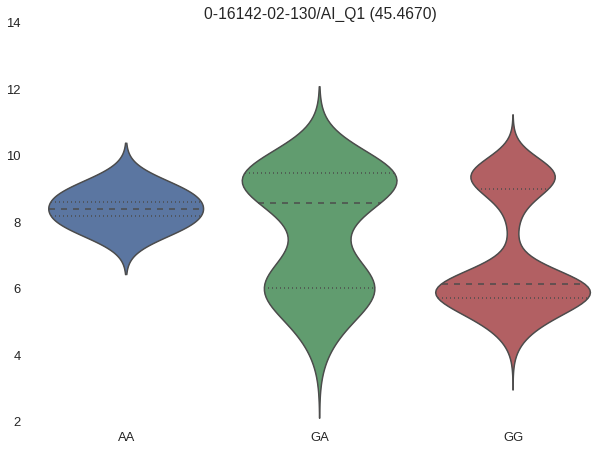

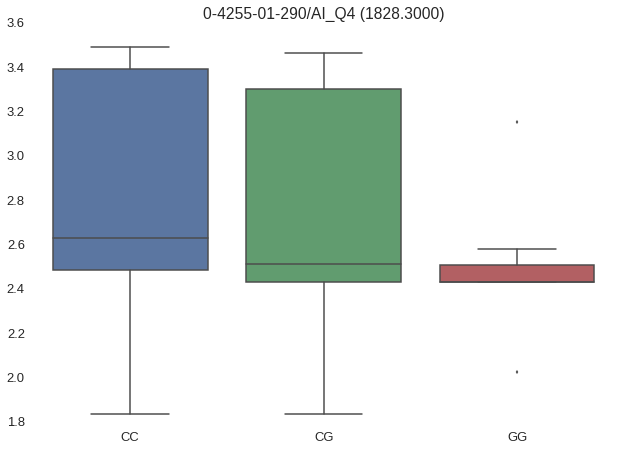

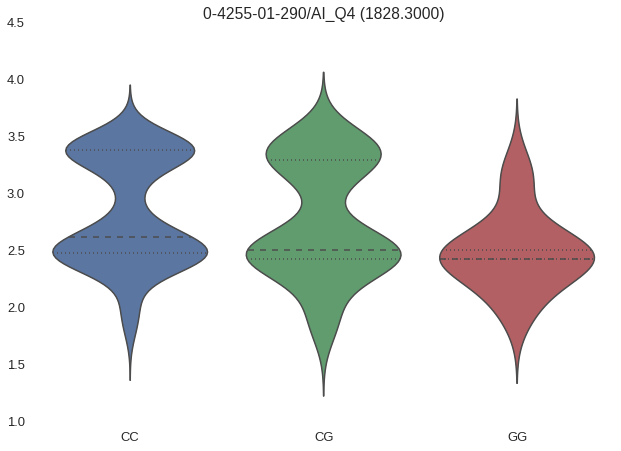

In [55]:
#bayenv_df_ai_basegt = bayenv_df_ai.apply(convert_to_snpassoc)
for env in boxplot_data:
    for snp in boxplot_data[env]:
        vals = {}
        for gt, group in bayenv_df_ai.groupby(snp):
            if not gt == 'NA':
                vals[gt.replace("/", "")] = group[env]
        vals = pd.DataFrame(vals, dtype=float)
        vals.index.name = env

        sns.boxplot([vals[x].dropna() for x in vals], 
                    names=vals.columns)
        plt.title("%s/%s (%.4f)" % (snp, vals.index.name, boxplot_data[env][snp]))
        plt.show()

        sns.violinplot([vals[x].dropna() for x in vals], 
                    names=vals.columns)
        plt.title("%s/%s (%.4f)" % (snp, vals.index.name, boxplot_data[env][snp]))
        plt.show()

In [56]:
perloc = hdf.get("perloc").T

In [57]:
xtx_files = !find {bayenv_dir} | grep xtx

In [58]:
xtx_data = {}
for f in xtx_files:
    f = open(f).readlines()[-1].split()
    f[0] = f[0].replace(".txt", "")
    xtx_data[f[0]] = float(f[1])

In [59]:
xtx = pd.Series(xtx_data)

In [60]:
xtx_perloc = pd.concat((xtx, perloc), axis=1)

In [61]:
cols = ["xtx"]
cols.extend(xtx_perloc.columns[1:])
xtx_perloc.columns = cols
xtx_perloc = xtx_perloc.dropna()
xtx_plot_data = xtx_perloc[xtx_perloc.Fst < 0.2]

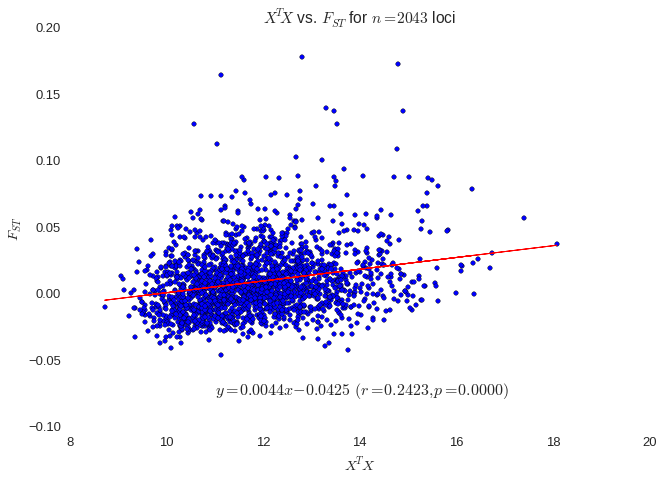

In [62]:
plt.scatter(xtx_plot_data.xtx, xtx_plot_data.Fst)
plt.title("$X^{T}\!X$ vs. $F_{ST}$ for $n = %d$ loci" % (len(xtx_plot_data)))
plt.xlabel("$X^T\!X$")
plt.ylabel("$F_{ST}$")
m, b, r, p, se = sp.stats.linregress(xtx_plot_data.xtx.values, xtx_plot_data.Fst.values)
plt.plot(xtx_plot_data.xtx, (xtx_plot_data.xtx*m + b), c="r", lw=1)
plt.text(11, -0.075, "$y = %.4fx %.4f \ (r = %.4f, p = %.4f)$" % (m, b, r, p), fontsize=16)
plt.show()